<a href="https://colab.research.google.com/github/Lenadeu/Time-series-anomaly-detection/blob/main/TF_anomaly_detection_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install sklearn.external.joblib 
!pip install statsmodels

#!pip install stldecompose
!pip install scipy

In [2]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#from sklearn.externals import joblib
#import sklearn.external.joblib as extjoblib
import joblib

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
#from tensorflow import set_random_seed
import tensorflow as tf
from tensorflow import keras
#tf.logging.set_verbosity(tf.logging.ERROR)





from statsmodels.tsa.seasonal import seasonal_decompose

# the main library has a small set of functionality
#from stldecompose import decompose, forecast
#from stldecompose.forecast_funcs import (naive,
#                                         drift, 
#                                         mean, 
#                                         seasonal_naive)


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

from scipy.fft import fft, fftfreq


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# set random seed
#Sets the global random seed.
seed(10)
tf.random.set_seed(10)

In [4]:
#from BatchModel import Data

# A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one 
# output tensor
#
from keras.models import Sequential

# Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise 
# activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True). 

# LSTM Long Short-Term Memory layer - Hochreiter 1997.

# Dropout. Applies Dropout to the input.

# The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during 
# training time, which helps prevent overfitting.
# Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

#RepeatVector Repeats the input n times

# TimeDistributed This wrapper allows to apply a layer to every temporal slice of an input.

# Every input should be at least 3D, and the dimension of index one of the first input
# will be considered to be the temporal dimension

# Activation 

from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Activation
# Regularizers allow you to apply penalties on layer parameters or layer activity during optimization.
# These penalties are summed into the loss function that the network optimizes.
from keras import regularizers



In [5]:
#splitting indexes between train and test data from files  
def get_splitting_ind_from_file(filename):
    
   
    split_ind = -1000000000
     
    #get extention 
    ext = os.path.splitext(filename)[-1].lower()
    
    print('ext=',ext)

    #if extention is not "txt" then return nothing
    if ext != ".txt":
        return '',''
    
    #get index of splitting from train to test from file name 
    split_ind_t = os.path.basename(filename).split('_')[3]
    split_ind=(int(split_ind_t[:-4]))
    
    
    
    return split_ind

In [6]:
#get train and test data for all series 
def get_train_test_data(time_series_df,split_ind):
    
    
    print('time series: ',time_series_df.head())

    print('split index',split_ind)

    train_df=time_series_df.iloc[0:split_ind,0]

    test_df=time_series_df.iloc[split_ind:-1,0]

    return test_df,train_df

In [7]:
def is_accurate(pred: int, start: int, end: int) -> bool:
    """Compute whether a prediction is accurate enough

    Args:
        pred (int): predicted time series step of the center of the anomaly
        start (int): true start of anomaly
        end (int): true end of anomaly

    Returns:
        bool: prediction is accurate
    """
    accepted_inaccuracy = 100  # slack for short anomalies
    length_anomaly = end - start + 1
    if (
        min(start - length_anomaly, start - accepted_inaccuracy)
        < pred
        < max(end + length_anomaly, end + accepted_inaccuracy)
    ):
        return True
    else:
        return False

In [8]:
# Draw Plot for pandas data frame using pyplot 
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [9]:
def period_estimation(time_series_df):
   
    autocor = []
    bunches = []
    this_bunch = []
    for i_lag in range(len(time_series_df.values)):
        if i_lag > 0.25: 
            ac = time_series_df['Data'].autocorr(lag=i_lag)
            autocor.append(ac)
            if ac < 0.25:
                if this_bunch:
                    bunches.append(this_bunch.copy())
                    this_bunch = []
            else:
                this_bunch.append(ac)

    fig1, ax1 = plt.subplots()  
  
    ax1.plot(bunches[1])
    ax1.plot(bunches[2])
    plt.show()

    P = autocor.index(max(bunches[2])) - autocor.index(max(bunches[1]))
    ax1.plot(autocor)
    plt.show()
    print('Period autocorrelation',P)

    return P





In [10]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))



In [11]:
#
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [12]:
def evaluation_time_series(series_filename,real_anomaly_start,real_anomaly_end):
    
    #for plotting with seaborn ############
    sns.set()
    #######################################
    
    #window for searching anomaly 
    #Anomaly_search_Window = 100
    
    #file with data  
    #print("file name = ",series_filename)
    path="drive/MyDrive/Colab Notebooks/AILab/Data/"
    
    # get time series from the file
    time_series_df = pd.read_csv(path+os.path.join(series_filename),names=['Data'])
    

    print('time seried data frame',time_series_df.head())

    print('time seried data frame',time_series_df)

    print('time_series_df shape = ',time_series_df.shape)


    fig, ax = plt.subplots()
    ax.plot(time_series_df.values)
    plt.title('initial series')

   

    #########################################################################################################

    ################ get period with autocorrelation

     
    P = period_estimation(time_series_df)

    
    #period 
    window_size=P


    ######################### test-train split 

    #
    split_ind=get_splitting_ind_from_file(series_filename)
    print('split index',split_ind)

    

    # get train-test data 
    #est_df,train_df = get_train_test_data(time_series_df,split_ind)

    #print('train_df head',train_df.head())

    #print('test_df head',test_df.head())

    # decomposition
  

    # Additive Decomposition. freq = period????????????????????????????????????
    result_add = seasonal_decompose(time_series_df, model='additive',freq = P)
    
    
    # Plot seasonal decomposition 
    plt.rcParams.update({'figure.figsize': (10,10)})
    result_add.plot().suptitle('Additive Decompose', fontsize=22)
    plt.show()
    

    ###########  


    # check stationarity with Dickey 

    # test_stationarity(time_series_df)
    # p-values = 0 -> stationary (series 32). d and D = 0 

    # Autocorrelation and partial autocorrelation plots 

    acf = plot_acf(time_series_df, lags=500)
    pacf = plot_pacf(time_series_df, lags=500)


    ##############################################################################
    ####################################### LSTM - autoencoder ###################

    ##### train - test split 

    series_len = len(time_series_df) 

    train_size = split_ind
    test_size = series_len - train_size
    train_df, test_df = time_series_df.iloc[0:train_size], time_series_df.iloc[train_size:series_len]
    print(train_df.shape, test_df.shape)

    ##### preprocessing 

    from sklearn.preprocessing import StandardScaler
    
    # Standardize feature/s by removing the mean and scaling to unit variance. Standart normal distribution
    scaler = StandardScaler()
    
    # Compute the mean and std to be used for later scaling.
    scaler = scaler.fit(train_df[['Data']])
    
    # Perform standardization by centering and scaling.
    train_df['Data'] = scaler.transform(train_df[['Data']])
    test_df['Data'] = scaler.transform(test_df[['Data']]) 

    ################# plot standartizied data 
    
    fig1, ax1 = plt.subplots(figsize=(14, 6), dpi=80)

    ax1.plot(train_df.index, train_df.values, c='b', label='train')
    ax1.plot(test_df.index, test_df.values, c='g', label='test')
    ax1.set_title('Standartizied data')

    plt.legend()
    plt.show() 

    ########################## 

    # ?
    TIME_STEPS = P

    # reshape to [samples, time_steps, n_features]

    X_train, y_train = create_dataset(train_df[['Data']], train_df.Data, TIME_STEPS)
    X_test, y_test = create_dataset(test_df[['Data']], test_df.Data, TIME_STEPS)

    print('X_train.shape',X_train.shape)
    print('X_test.shape',X_test.shape)
    print('y_train.shape',y_train.shape)
    print('y_test.shape',y_test.shape)
    
    ##### model 

    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

    #loss - mean absolute error 
    model.compile(loss='mae', optimizer='adam')

    #### fitting

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. 
    # Do not specify the batch_size if your data is in the form of datasets, 
    # generators, or keras.utils.Sequence instances (since they generate batches
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1, shuffle=False)
   
    #############################################################################
    
    # loss on train data, loss on validation data
    fig1, ax1 = plt.subplots(figsize=(14, 6), dpi=80)

    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='test-validation')

    plt.legend()
    plt.show() 

    # prediction for train data 
    X_train_pred = model.predict(X_train)

    print('X_train_pred',X_train_pred.shape)

    # loss on train data 
    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

    # mean absolute error (MAE) from train data 
    print('train_mae_los shape = ', train_mae_loss.shape)

    # distribution of MAE 
    sns.distplot(train_mae_loss, bins=100, kde=True, label='train mae loss')

    # threshold choosen from MAE distribution 

    #THRESHOLD = np.max(train_mae_loss)-np.max(train_mae_loss)/100*20
    THRESHOLD = 1.2
    print(f'Reconstruction error threshold: {THRESHOLD}')

    ############ test data 

    # prediction for test data 
    X_test_pred = model.predict(X_test)

    print('X_test_pred shape = ',X_test_pred.shape)

    # MAE for test data 
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

    print('test_mae_los shape =',test_mae_loss.shape)

    ############## scores 

    test_score_df = pd.DataFrame(index=test_df.index[TIME_STEPS:])
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df['Data'] = test_df.values[TIME_STEPS:]

    print('test_df.values shape ',test_df.values.shape)
    print('test_df.index shape',test_df.index.shape)
    
    print('test_score_df.head()',test_score_df.head())
    print('test_score_df',test_score_df)

    ##### plotting 

    fig2, ax2 = plt.subplots(figsize=(14, 6), dpi=80)


    ax2.plot(test_score_df.index, test_score_df.loss, label='test mae loss')
    ax2.plot(test_score_df.index, test_score_df.threshold, label='threshold')
    #ax2.xticks(rotation=25)
    ax2.legend()
    plt.show()

    ## anomalies dataframe 

    # choose only rows from test_score_df where anamolies == true  
    anomalies = test_score_df[test_score_df.anomaly == True]
    
    print('anomalies.head()', anomalies.head())
    print('anomaly time series value ', anomalies['Data'])
    print('anomaly indeces', anomalies.index)
    
    #anomalies.set_index(anomalies.index,inplace=True)

    #print('anomalies ind',anomalies.index)
    
    # number of anamoly points 
    anomaly_num = len(anomalies.index)

    ### plot anomaly points and time series  

    fig3, ax3 = plt.subplots(figsize=(14, 6), dpi=80)

    # plot initial test data 
    ax3.plot(test_df.index, scaler.inverse_transform(test_df.values), label='test data')


    print('anomalies.index size',np.size(list(anomalies.index)))
    # print('test_df[anomalies.index] size',np.size(test_df[test_df.index==anomalies.index]))

    print('anomalies.index',list(anomalies.index))
    print('scaler.inverse_transform(anomalies[Data])',scaler.inverse_transform(anomalies[['Data']]))

    # initial time series values at points detected as anomalies 
    anamolious_values = np.reshape(scaler.inverse_transform(anomalies[['Data']]),(anomaly_num,1))

    print('anamolious_values = ',anamolious_values)

    # transform to list from list of lists 
    anamolious_values = [item for sublist in anamolious_values for item in sublist]

    print('anamolious_values',anamolious_values)


    #sns.scatterplot(anomalies.index,scaler.inverse_transform(anomalies.Data),color=sns.color_palette()[3] , s = 52,label = 'anomaly')
    
    sns.scatterplot(list(anomalies.index),anamolious_values, color=sns.color_palette()[3], s = 20, label = 'anomaly')
    
    #ax3.xticks(rotation=25)
    ax3.legend()
    plt.show()
   


    #############################################################################

    anomaly_ind_pred = anomalies.index[anomalies['loss']==np.max(anomalies['loss'])]

    print('np.max(anomalies[loss])',np.max(anomalies['loss']))

    print('anomaly_ind_predicted',anomaly_ind_pred)
    

   # print('anomaly_ind_predicted',anomaly_ind_pred)
    
    print('real anomaly start',real_anomaly_start)
    
    print('real anomaly end',real_anomaly_end)
        
    
    ########################### evaluate #########################################
    return is_accurate(anomaly_ind_pred, real_anomaly_start,real_anomaly_end)
    

In [13]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 16 18:54:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [15]:
meta_data_link='https://drive.google.com/file/d/1fReFeSTm3Kf2gUyQ_tC-zLjkRBp5zdjd/view?usp=sharing'

In [16]:
split = meta_data_link.split('/')
id=split[-2]
print (id) #

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
meta_data_df = pd.read_csv('Filename.csv')
# Dataset is now stored in a Pandas Dataframe

#meta data 
meta_data_df.head()

print('anomaly start',meta_data_df['anomaly_start'])
print('anomaly end',meta_data_df['anomaly_end'])


1fReFeSTm3Kf2gUyQ_tC-zLjkRBp5zdjd
anomaly start 0       52000
1       56600
2       46600
3        5400
4        5391
        ...  
245    270800
246    121900
247      4702
248      8285
249      7290
Name: anomaly_start, Length: 250, dtype: int64
anomaly end 0       52620
1       56900
2       46900
3        5600
4        5392
        ...  
245    271070
246    121980
247      4707
248      8315
249      7296
Name: anomaly_end, Length: 250, dtype: int64


In [17]:
# Get the list of all files 
# in the directory Data_excel
data_dir_link = "https://drive.google.com/drive/folders/1YbhV3K6VTNJn10joLIc8FmX2UXbj1V_v?usp=sharing"

split1 = data_dir_link.split('/')
id=split1[-1]

print(id)

split2 = id.split('=')

id2 = split2[-2]

print(id2)


# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

import os
os.listdir()

data_files = os.listdir('drive/MyDrive/Colab Notebooks/AILab/Data')



1YbhV3K6VTNJn10joLIc8FmX2UXbj1V_v?usp=sharing
1YbhV3K6VTNJn10joLIc8FmX2UXbj1V_v?usp
Mounted at /content/drive


Files with data ['170_UCR_Anomaly_18500.txt', '153_UCR_Anomaly_14000.txt', '082_UCR_Anomaly_70000.txt', '060_UCR_Anomaly_22000.txt', '047_UCR_Anomaly_18000.txt', '237_UCR_Anomaly_19313.txt', '127_UCR_Anomaly_5000.txt', '140_UCR_Anomaly_1000.txt', '116_UCR_Anomaly_4000.txt', '208_UCR_Anomaly_5130.txt', '174_UCR_Anomaly_3700.txt', '118_UCR_Anomaly_4000.txt', '216_UCR_Anomaly_37216.txt', '246_UCR_Anomaly_100211.txt', '175_UCR_Anomaly_5200.txt', '233_UCR_Anomaly_18913.txt', '195_UCR_Anomaly_17000.txt', '070_UCR_Anomaly_17555.txt', '113_UCR_Anomaly_4000.txt', '086_UCR_Anomaly_20000.txt', '196_UCR_Anomaly_20000.txt', '089_UCR_Anomaly_100000.txt', '205_UCR_Anomaly_9812.txt', '066_UCR_Anomaly_3700.txt', '032_UCR_Anomaly_1000.txt']
file ids [170, 153, 82, 60, 47, 237, 127, 140, 116, 208, 174, 118, 216, 246, 175, 233, 195, 70, 113, 86, 196, 89, 205, 66, 32]
metadata of files from phase 1      data_id                        name  train_end_idx  anomaly_start  \
31        32  DISTORTEDInternalBlee

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


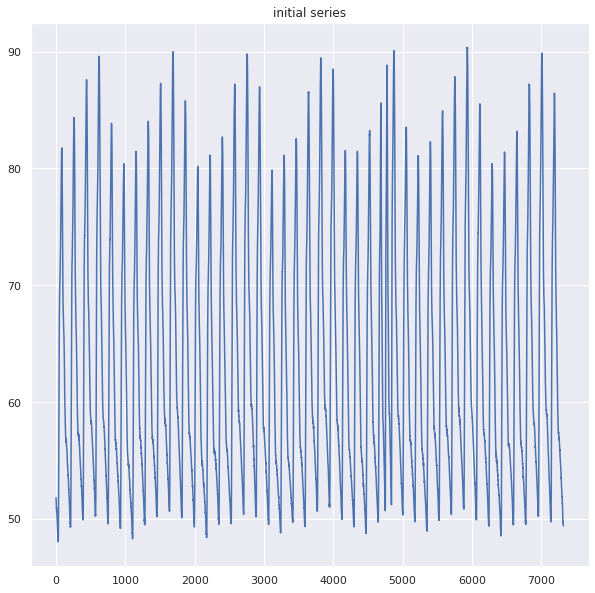

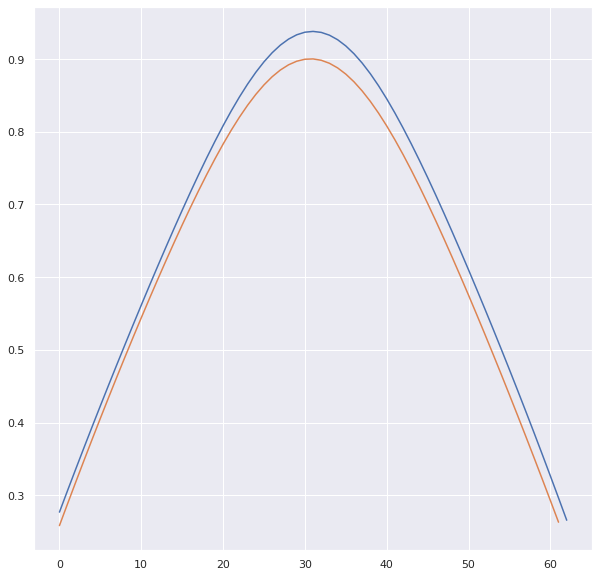

Period autocorrelation 178
ext= .txt
split index 1000


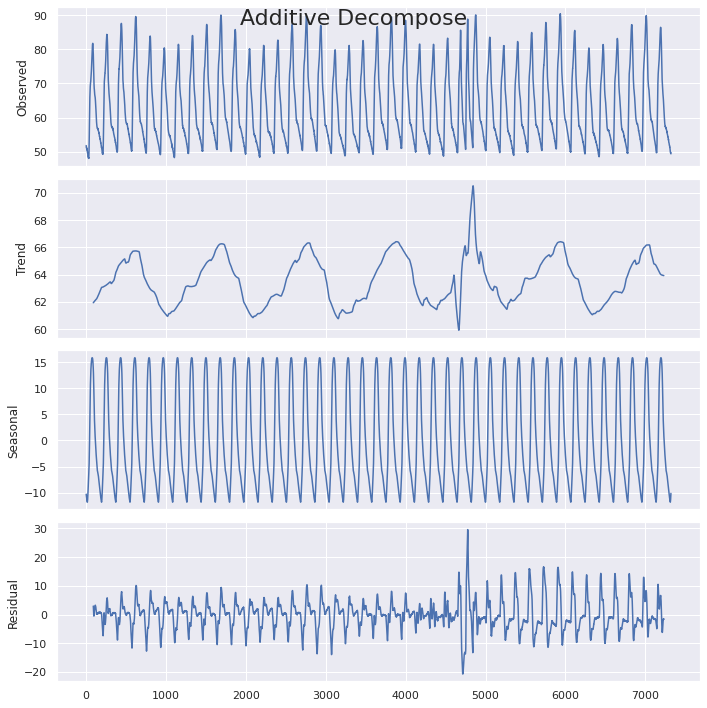

(1000, 1) (6321, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


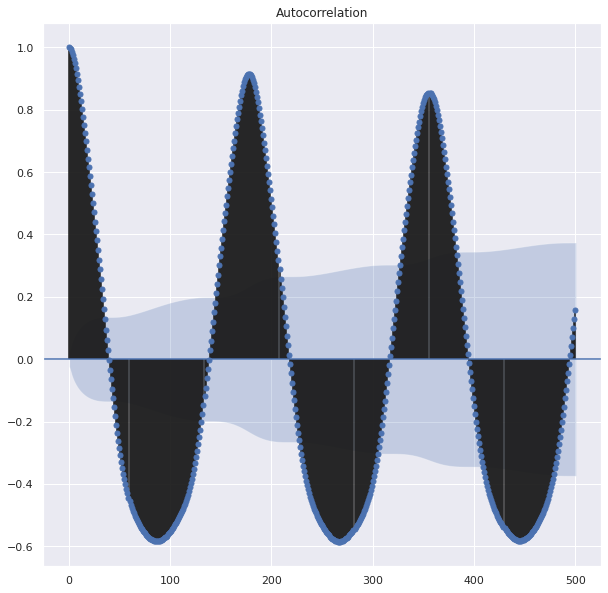

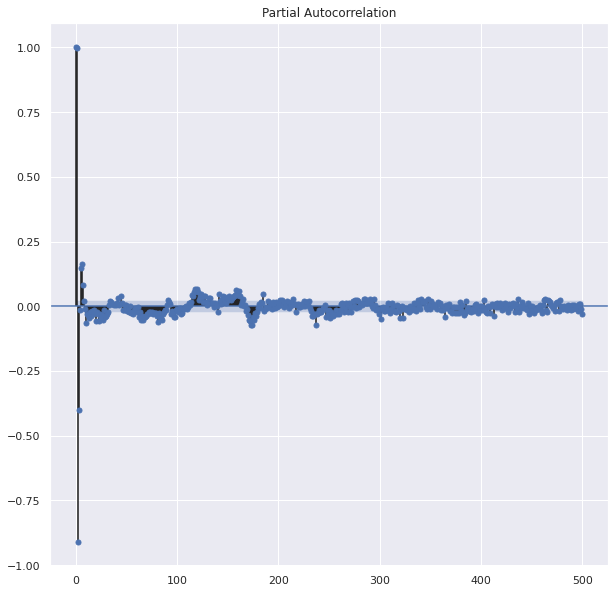

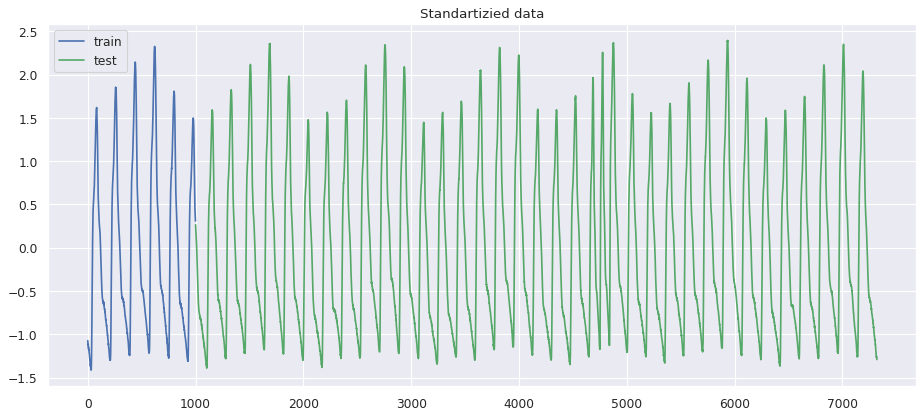

X_train.shape (822, 178, 1)
X_test.shape (6143, 178, 1)
y_train.shape (822,)
y_test.shape (6143,)
Epoch 1/5
24/24 [==============================] - 4s 50ms/step - loss: 0.6209 - val_loss: 0.4895
Epoch 2/5
24/24 [==============================] - 0s 16ms/step - loss: 0.3926 - val_loss: 0.4839
Epoch 3/5
24/24 [==============================] - 0s 16ms/step - loss: 0.3905 - val_loss: 0.4896
Epoch 4/5
24/24 [==============================] - 0s 16ms/step - loss: 0.3901 - val_loss: 0.4940
Epoch 5/5
24/24 [==============================] - 0s 15ms/step - loss: 0.3905 - val_loss: 0.4884


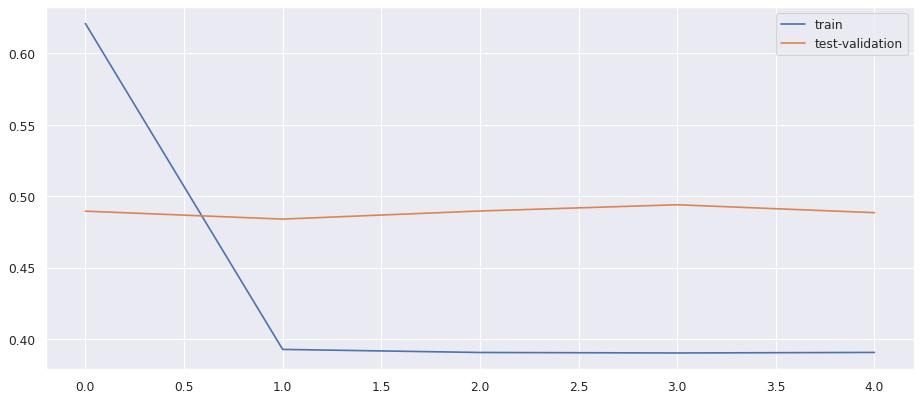

X_train_pred (822, 178, 1)
train_mae_los shape =  (822, 1)
Reconstruction error threshold: 1.2


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


X_test_pred shape =  (6143, 178, 1)
test_mae_los shape = (6143, 1)
test_df.values shape  (6321, 1)
test_df.index shape (6321,)
test_score_df.head()           loss  threshold  anomaly      Data
1178  0.934979        1.2    False  0.286856
1179  0.923788        1.2    False  0.262491
1180  0.914210        1.2    False  0.237783
1181  0.905794        1.2    False  0.223714
1182  0.898906        1.2    False  0.227489
test_score_df           loss  threshold  anomaly      Data
1178  0.934979        1.2    False  0.286856
1179  0.923788        1.2    False  0.262491
1180  0.914210        1.2    False  0.237783
1181  0.905794        1.2    False  0.223714
1182  0.898906        1.2    False  0.227489
...        ...        ...      ...       ...
7316  1.237890        1.2     True -1.265275
7317  1.245325        1.2     True -1.256696
7318  1.248648        1.2     True -1.260814
7319  1.250857        1.2     True -1.277629
7320  1.254106        1.2     True -1.290669

[6143 rows x 4 columns]


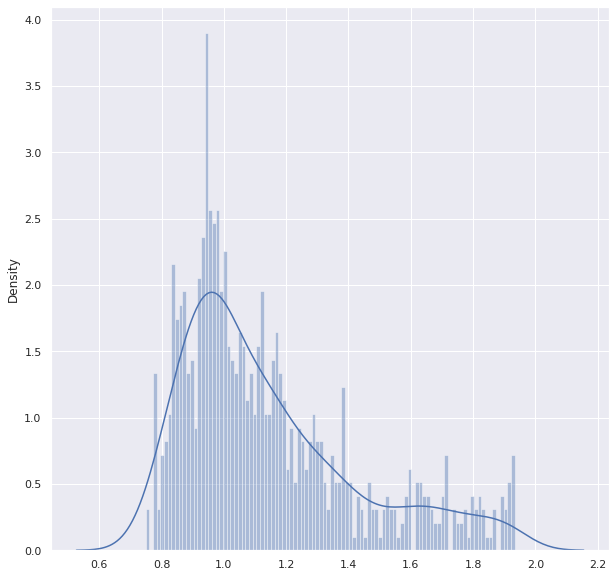

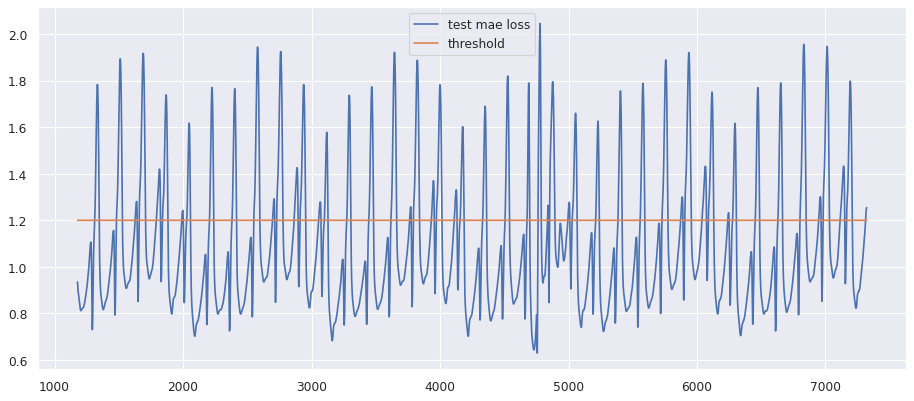

anomalies.head()           loss  threshold  anomaly      Data
1313  1.211947        1.2     True  1.059319
1314  1.235490        1.2     True  1.086771
1315  1.258141        1.2     True  1.150943
1316  1.286931        1.2     True  1.200702
1317  1.317896        1.2     True  1.255265
anomaly time series value  1313    1.059319
1314    1.086771
1315    1.150943
1316    1.200702
1317    1.255265
          ...   
7316   -1.265275
7317   -1.256696
7318   -1.260814
7319   -1.277629
7320   -1.290669
Name: Data, Length: 1673, dtype: float64
anomaly indeces Int64Index([1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322,
            ...
            7206, 7207, 7313, 7314, 7315, 7316, 7317, 7318, 7319, 7320],
           dtype='int64', length=1673)
anomalies.index size 1673
anomalies.index [1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


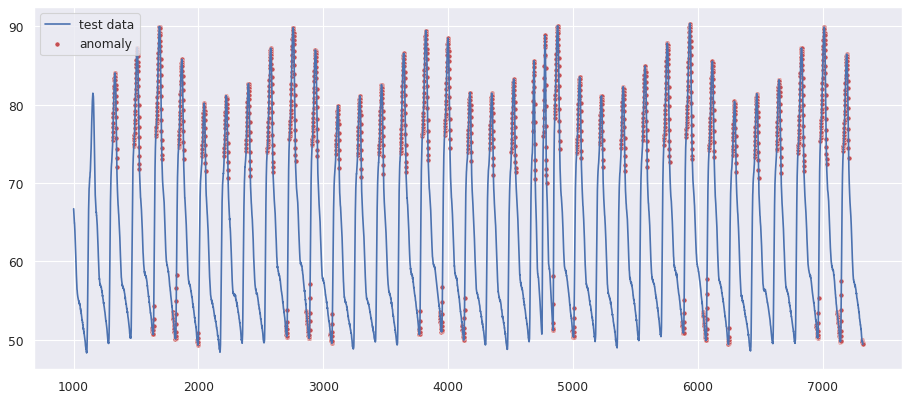

np.max(anomalies[loss]) 2.04479731174873
anomaly_ind_predicted Int64Index([4778], dtype='int64')
real anomaly start [4675]
real anomaly end [5033]
evaluation  True


In [20]:
#from pandas import DataFrame

#print all data files 
print("Files with data", data_files) 


#get the id of files from its names 
file_ids=[]
for i in range(0,len(data_files)):
    split_=data_files[i].split('_')[0]
    file_ids.append(int(split_[0:3]))

print('file ids',file_ids)

#get meta data for phase1 files (there are metadata on all files in metadata.csv)
meta_data_ph1 = meta_data_df[ meta_data_df['data_id'].isin(file_ids) ]

print('metadata of files from phase 1',meta_data_ph1)


#number of the file 
file_num = 7
#id of the file 
file_id = file_ids[file_num]
#file name 
file_name=data_files[file_num]

print('file index',file_num)
print('file id',file_id)
print('file name',file_name)

#metadata of the file 
metadata_of_file_num=meta_data_df[ meta_data_df['data_id'] == file_id ]
print('metadata of the file',metadata_of_file_num)

#real start of anomaly 
anomaly_start_real=metadata_of_file_num['anomaly_start'].values
print('anomaly_start_real',anomaly_start_real)
print(np.shape(anomaly_start_real))
print(np.size(anomaly_start_real))

#real end of anomaly 
anomaly_end_real=metadata_of_file_num['anomaly_end'].values
print('anomaly_end_real',anomaly_end_real)
print(np.shape(anomaly_end_real))
print(np.size(anomaly_end_real))


#evaluate 
#print('file',file_name,'start',anomaly_start_real,'end',anomaly_end_real)

eval_res=evaluation_time_series(file_name,anomaly_start_real,anomaly_end_real)

print('evaluation ',eval_res)
